





##This notebook intends to analyze and create a model on the PIMA Indian Diabetes dataset to predict the onset diabetes based on simple diagnostic measures
<center><h3><a href="https://ibrahim-projets.herokuapp.com/projets/diabetes/" target="_top">Try the web app</a></h3></center>
[Try the web app](https://ibrahim-projets.herokuapp.com/projets/diabetes/)



In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')
# the project's folder
%cd /gdrive/'My Drive'/projets

Mounted at /gdrive
/gdrive/My Drive/projets


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time 
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder

In [ ]:
df=pd.read_csv('/gdrive/My Drive/projets/diabetes_pima.csv')


In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,129,70,18,122,29.43,1.17,45,1
1,1,205,76,36,249,37.28,0.92,29,1
2,8,97,82,0,0,37.82,0.59,68,0
3,7,141,90,41,0,34.25,0.40,39,0
4,4,120,72,0,0,29.12,0.39,46,1


In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

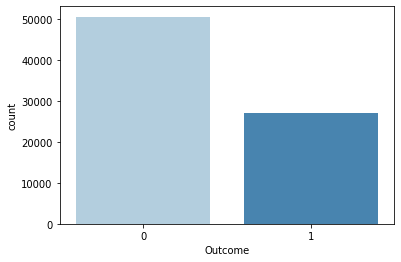

In [ ]:
sns.countplot(x = df.Outcome, data = df, palette = "Blues");

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5794b31320>,
      dtype=object)

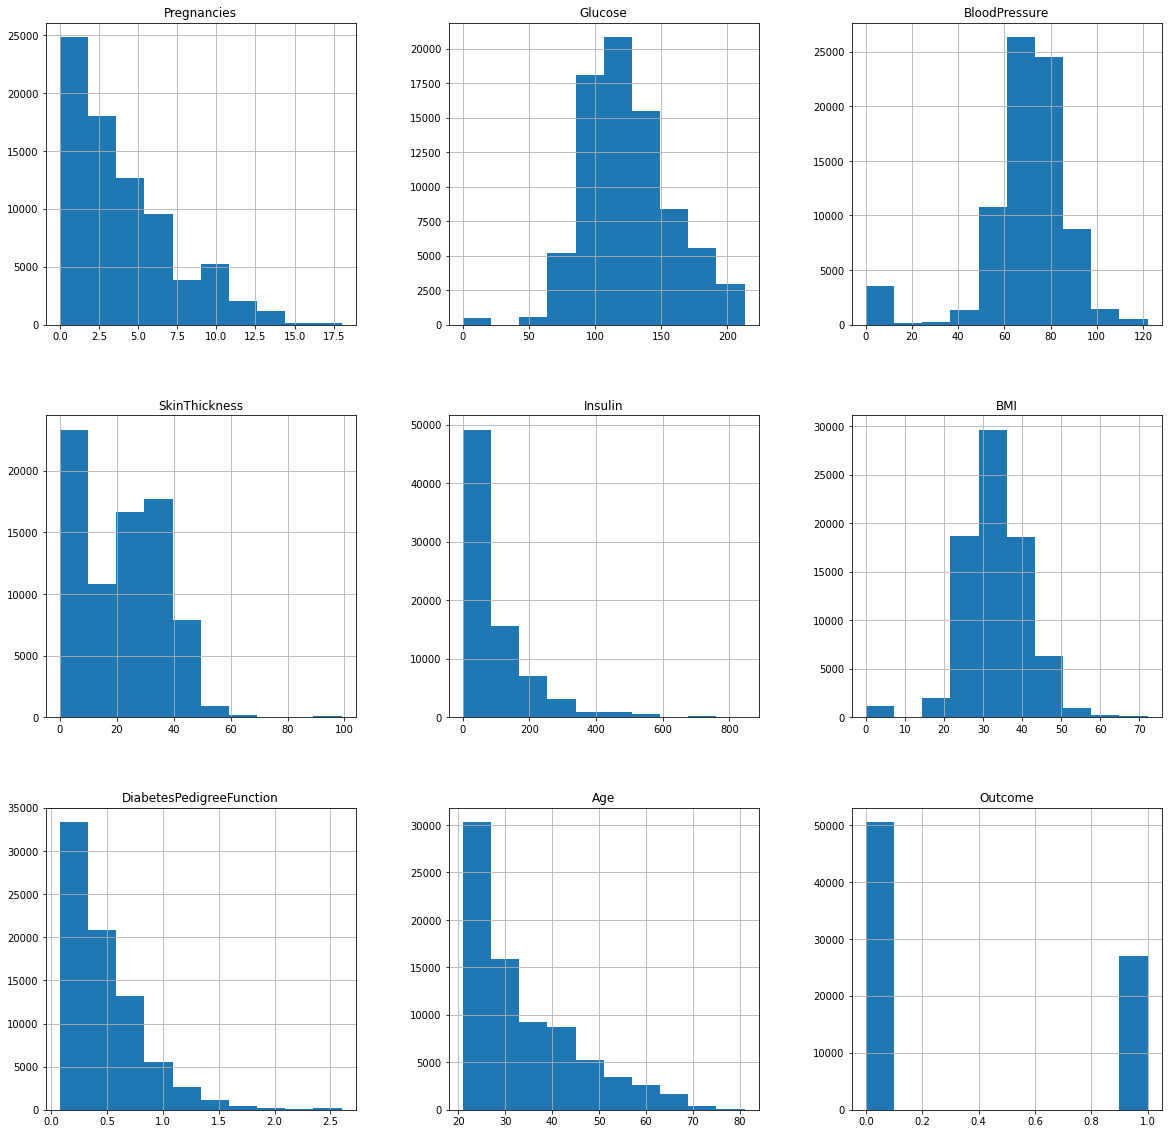

In [ ]:
df.hist(figsize = (20,20))

In [ ]:
target= df.Outcome                       
feature_to_remove = ['Outcome']
df = df.drop(feature_to_remove,axis = 1 )
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,4,129,70,18,122,29.43,1.17,45
1,1,205,76,36,249,37.28,0.92,29
2,8,97,82,0,0,37.82,0.59,68
3,7,141,90,41,0,34.25,0.40,39
4,4,120,72,0,0,29.12,0.39,46


In [ ]:
df.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,77568.000000,77568.000000,77568.000000,77568.000000,77568.000000,77568.000000,77568.000000,77568.000000
mean,3.845516,124.884488,69.105469,20.536458,79.799479,33.181591,0.489430,33.240885
std,3.369130,33.202236,19.343326,15.941931,115.169692,8.205376,0.343634,11.752648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,28.140000,0.250000,24.000000
50%,3.000000,121.000000,72.000000,23.000000,30.500000,33.230000,0.390000,29.000000
75%,6.000000,145.000000,80.000000,32.000000,127.250000,37.910000,0.650000,41.000000
max,18.000000,213.000000,122.000000,99.000000,846.000000,72.120000,2.600000,81.000000


##Visualization
<p>Before violin and swarm plot visualization we need to normalize or standardize.</p>


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

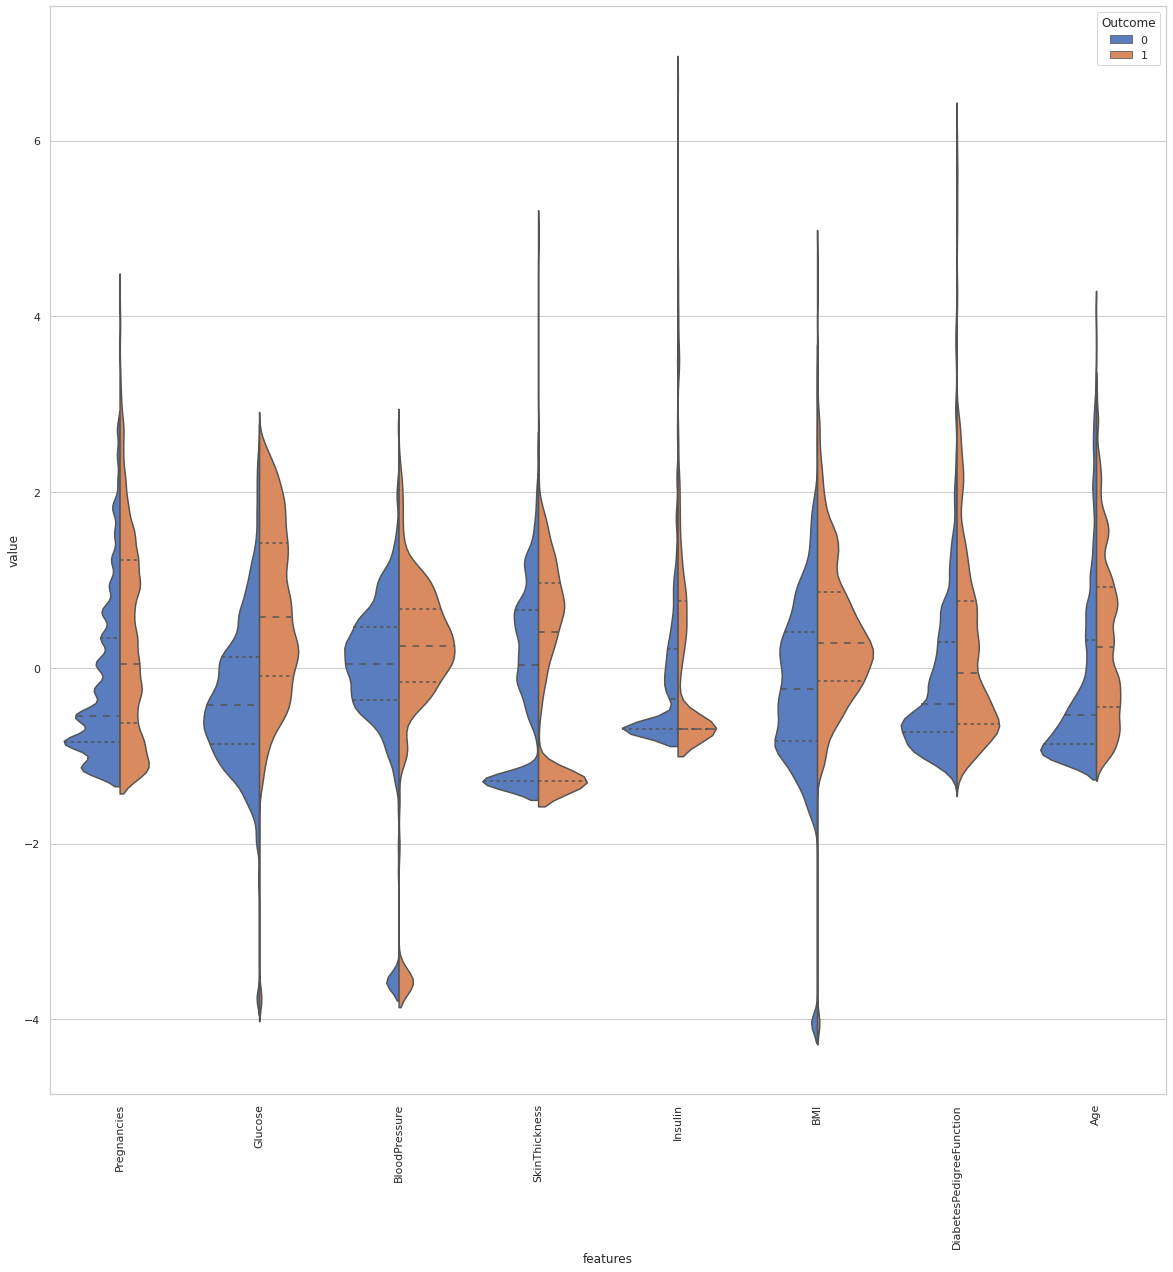

In [ ]:
data = (df- df.mean()) / (df.std())              # standardization
data = pd.concat([target,data],axis=1)
data = pd.melt(data,id_vars="Outcome",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
sns.violinplot(x="features", y="value", hue="Outcome", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

KeyboardInterrupt: ignored

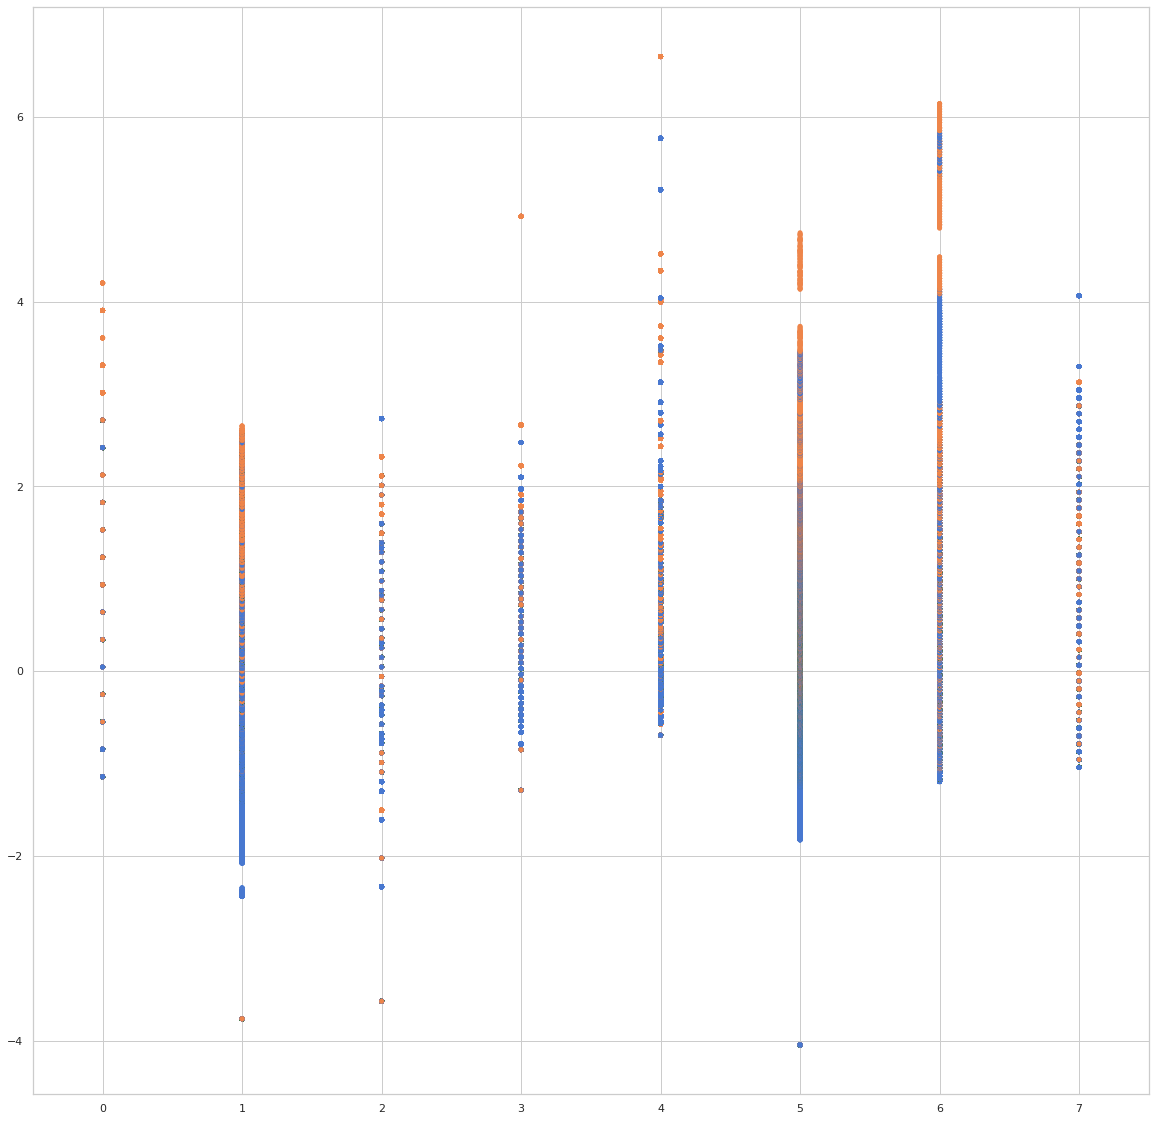

In [ ]:
sns.set(style="whitegrid", palette="muted")
data = (df- df.mean()) / (df.std())       
data = pd.concat([target,data],axis=1)
data = pd.melt(data,id_vars="Outcome",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
sns.swarmplot(x="features", y="value", hue="Outcome", data=data)
#sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

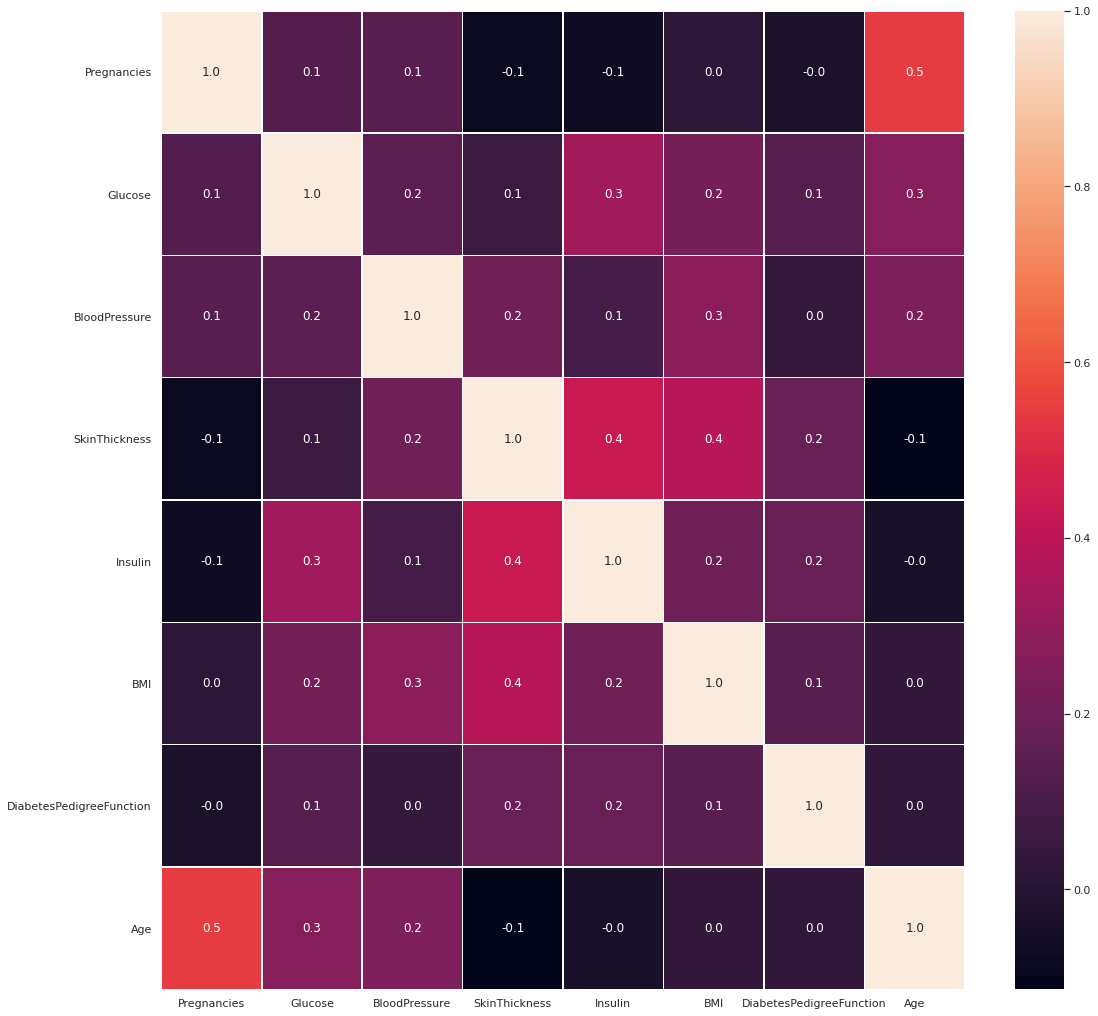

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

###LGBM

In [ ]:
def display_importances(feature_importance_df_):
  cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
  best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
  plt.figure(figsize=(8, 10))
  sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
  plt.title('LightGBM Features (avg over folds)')
  plt.tight_layout()
  plt.savefig('lgbm_importances01.png')

In [ ]:
def kfold_stratified_lightgbm(X_train,X_test,y_train,y_test, num_folds, stratified = False):
  #training test data
  train_df=X_train
  test_df=X_test
  print("type X_train",type(X_train))
  print("type X_test",type(X_test))
  print("type y_train",type(y_train))
  print("type y_test",type(y_test))
  print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
  
  # Cross validation model
  if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
  else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
  
  # Create arrays and dataframes to store results
  oof_preds = np.zeros(train_df.shape[0])
  sub_preds = np.zeros(test_df.shape[0])

  feature_importance_df = pd.DataFrame()
  feats =list(train_df.columns)
  
  for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df,y_train)):
    train_x, train_y = train_df.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = train_df.iloc[valid_idx],y_train.iloc[valid_idx]

    clf = LGBMClassifier(
            nthread=3,
        
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=31,
            objective='binary',
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            )
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y

  print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))
  # plot feature importance
  display_importances(feature_importance_df)
  return feature_importance_df

type X_train <class 'pandas.core.frame.DataFrame'>
type X_test <class 'pandas.core.frame.DataFrame'>
type y_train <class 'pandas.core.series.Series'>
type y_test <class 'pandas.core.series.Series'>
Starting LightGBM. Train shape: (54297, 8), test shape: (23271, 8)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[560]	training's auc: 1	training's binary_logloss: 0.0627547	valid_1's auc: 1	valid_1's binary_logloss: 0.0648284
Fold  1 AUC : 1.000000
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[546]	training's auc: 0.999999	training's binary_logloss: 0.0679238	valid_1's auc: 1	valid_1's binary_logloss: 0.070423
Fold  2 AUC : 1.000000
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[508]	training's auc: 0.999998	training's binary_logloss: 0.0720511	valid_1's auc: 1	valid_1's binary_logloss: 0.0743756
Fold  3 AUC : 1.000000
Training until va

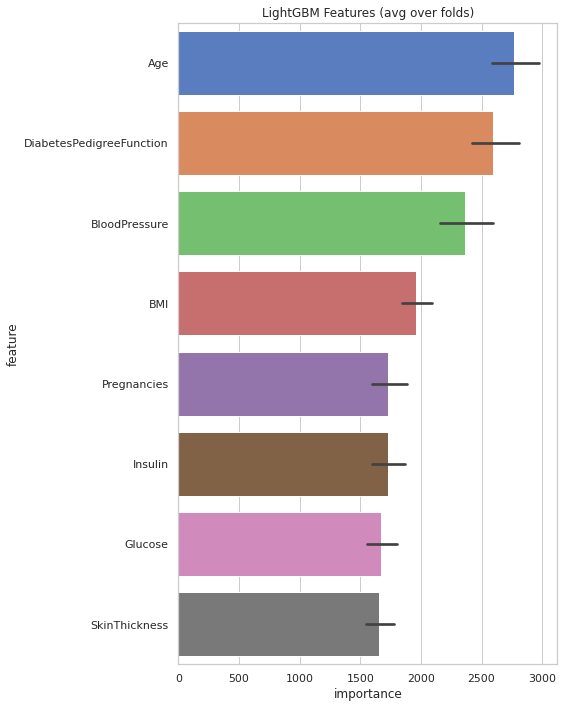

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(df,target , test_size=0.3, random_state=42)
 features_importance = kfold_stratified_lightgbm(X_train,X_test,y_train,y_test, num_folds= 12, stratified= False)

In [ ]:
 features_importance=features_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
 features_selected=list(features_importance)
 features_selected

['Age',
 'DiabetesPedigreeFunction',
 'BloodPressure',
 'BMI',
 'Insulin',
 'Pregnancies',
 'Glucose',
 'SkinThickness']

In [ ]:
X_train=X_train[features_selected]
X_test = X_test[features_selected]
clf = LGBMClassifier(
            nthread=3,
        n_estimators=1000,
            learning_rate=0.02,
            num_leaves=31,
            objective='binary',
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            )
clf.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_test, y_test)], 
            eval_metric= 'auc', verbose= 600, early_stopping_rounds= 500)

Training until validation scores don't improve for 500 rounds.
[600]	training's auc: 1	training's binary_logloss: 0.0561551	valid_1's auc: 1	valid_1's binary_logloss: 0.0578168
Did not meet early stopping. Best iteration is:
[779]	training's auc: 1	training's binary_logloss: 0.0372143	valid_1's auc: 1	valid_1's binary_logloss: 0.0384431


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9497036, importance_type='split',
               learning_rate=0.02, max_depth=8, min_child_samples=20,
               min_child_weight=40, min_split_gain=0.0222415, n_estimators=1000,
               n_jobs=-1, nthread=3, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.04, reg_lambda=0.073, silent=-1,
               subsample=0.8715623, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

In [ ]:
filename='pima_dataset_lgbm_final.txt'
clf.booster_.save_model(filename)

###RANDOM FOREST

Accuracy is:  1.0


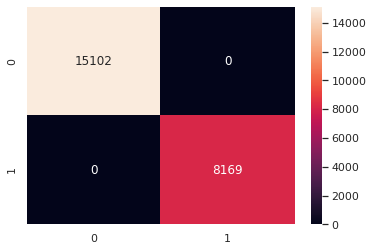

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and test 30 %
X_train, X_test, y_train, y_test = train_test_split(df,target , test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=42)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

###Neural Networks

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(df,target , test_size=0.3, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Build neural network with Keras
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=8))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, verbose=False)

# Results - Accuracy
scores = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

Training Accuracy: 100.00%

Testing Accuracy: 100.00%



[Try the web app](https://ibrahim-projets.herokuapp.com/projets/diabetes/)
